In [15]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline


In [2]:
import sys
sys.path.append("..")
from conf import ROOT_DIR
os.chdir(ROOT_DIR)

In [3]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()
        
        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')
        
# Done!
print(f'All data downloaded')



Directory already downloaded: e:\Tue_Study\Q3\5LSM0_CNN\5LSM0_Cityscapes_challenge\data\gtFine
Directory already downloaded: e:\Tue_Study\Q3\5LSM0_CNN\5LSM0_Cityscapes_challenge\data\leftImg8bit
All data downloaded


In [4]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue
        
    print(f'Preprocessing: {dir_full}')
        
    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue
            
        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')
        
        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)
        
        for f in files:
            if not f.endswith('.png'):
                continue
            
            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)
            
print(f'Preprocessing done')


Preprocessed directory already exists: e:\Tue_Study\Q3\5LSM0_CNN\5LSM0_Cityscapes_challenge\data\gtFine_256_128
Preprocessed directory already exists: e:\Tue_Study\Q3\5LSM0_CNN\5LSM0_Cityscapes_challenge\data\leftImg8bit_256_128
Preprocessing done


In [5]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str
    
    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))
    
    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))
            
    
# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str
    id: int
    color: Tuple[int, int, int]

# List of classes that we want to detect in the input
classes = [
    CityscapesClass('void', 0, (0, 0, 0)),
    CityscapesClass('dynamic', 1, (111, 74, 0)),
    CityscapesClass('ground', 2, (81, 0, 81)),
    CityscapesClass('road', 3, (128, 64, 128)),
    CityscapesClass('sidewalk', 4, (244, 35, 232)),
    CityscapesClass('parking', 5, (250, 170, 160)),
    CityscapesClass('rail track', 6, (230, 150, 140)),
    CityscapesClass('building', 7, (70, 70, 70)),
    CityscapesClass('wall', 8, (102, 102, 156)),
    CityscapesClass('fence', 9, (190, 153, 153)),
    CityscapesClass('guard rail', 10, (180, 165, 180)),
    CityscapesClass('bridge', 11, (150, 100, 100)),
    CityscapesClass('tunnel', 12, (150, 120, 90)),
    CityscapesClass('pole', 13, (153, 153, 153)),
    CityscapesClass('polegroup', 14, (153, 153, 153)),
    CityscapesClass('traffic light', 15, (250, 170, 30)),
    CityscapesClass('traffic sign', 16, (220, 220, 0)),
    CityscapesClass('vegetation', 17, (107, 142, 35)),
    CityscapesClass('terrain', 18, (152, 251, 152)),
    CityscapesClass('sky', 19, (70, 130, 180)),
    CityscapesClass('person', 20, (220, 20, 60)),
    CityscapesClass('rider', 21, (255, 0, 0)),
    CityscapesClass('car', 22, (0, 0, 142)),
    CityscapesClass('truck', 23, (0, 0, 70)),
    CityscapesClass('bus', 24, (0, 60, 100)),
    CityscapesClass('caravan', 25, (0, 0, 90)),
    CityscapesClass('trailer', 26, (0, 0, 110)),
    CityscapesClass('train', 27, (0, 80, 100)),
    CityscapesClass('motorcycle', 28, (0, 0, 230)),
    CityscapesClass('bicycle', 29, (119, 11, 32)),
]


In [6]:
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List

import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()
        
        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample) # input is a RGB picture
        truth = self.load_truth(sample) # ground truth is a RGB image

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        
        pass
        
        ################################################################################# 
        
        # Convert the image to a tensor
        img = TF.to_tensor(img)
        
        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target += eq * i

        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(i)

            target[0] += eq * lbl.color[0]
            target[1] += eq * lbl.color[1]
            target[2] += eq * lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')
    
# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val", "test")
}

Subset,Amount,Size,Input sample,Truth sample
train,2975,256×128,,
val,500,256×128,,
test,1525,256×128,,

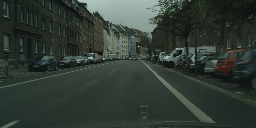
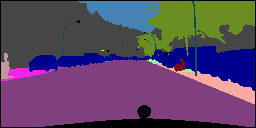
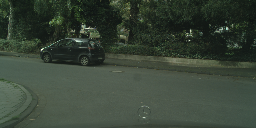
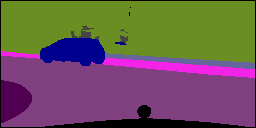
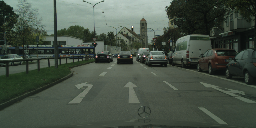
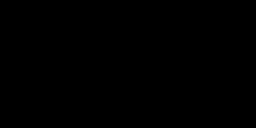

In [7]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split.items():    
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    
    input = TF.to_pil_image(input)
    truth = ds_sub.to_image(truth)
    
    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth: 
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


# Test ds_split

In [8]:
trainSet=ds_split["train"]

In [9]:
trainSet[0][1]

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0, 19, 27,  ..., 17, 17,  0],
        [ 0, 19, 27,  ..., 17, 17,  0],
        ...,
        [ 0,  3,  3,  ...,  3,  3,  0],
        [ 0,  3,  3,  ...,  3,  3,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], dtype=torch.uint8)

In [10]:
output1=torch.zeros((10,*trainSet[0][1].shape))
row_step=64     # 128/64=2
column_step=64  # 256/64=4
step=0
for i in range(int(output1[0].shape[0]/row_step)):
    for j in range(int(output1[0].shape[1]/column_step)):
        output1[step][i*row_step:(i+1)*row_step,j*column_step:(j+1)*column_step]=1
        step+=1
output2=torch.zeros((10,*trainSet[0][1].shape))
row_step=64     # 128/64=2
column_step=64  # 256/64=4
step=1
for i in range(int(output2[0].shape[0]/row_step)):
    for j in range(int(output2[0].shape[1]/column_step)):
        output2[step][i*row_step:(i+1)*row_step,j*column_step:(j+1)*column_step]=1
        step+=1
        step=step%8

In [11]:
plt.imshow(output1.argmax(0))
plt.imshow(output2.argmax(0))
output_batch=torch.stack([output1,output2])
output_map=output_batch.argmax(dim=1)

Error: Canceled future for execute_request message before replies were done

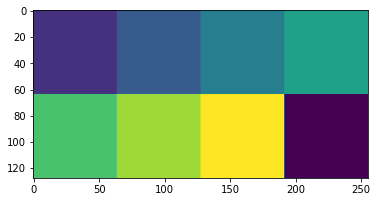

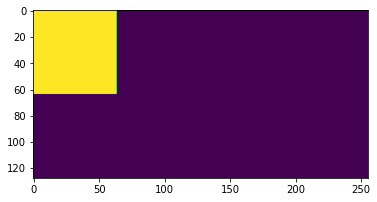

In [ ]:
plt.imshow((output_map==1)[1])

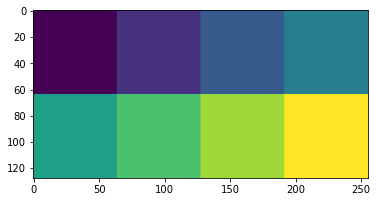

In [ ]:
plt.imshow(output_map[0])

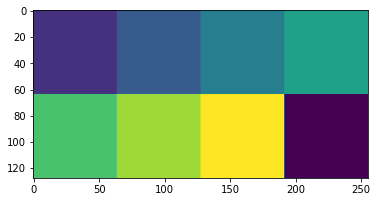

In [ ]:
plt.imshow(output_map[1])

In [ ]:
def IoU(pred: torch.tensor,truth:torch.tensor,class_label:int) -> float:
    inter_map=torch.logical_and(pred==class_label,truth==class_label)
    union_map=torch.logical_or(pred==class_label,truth==class_label)
    return inter_map,union_map,inter_map.sum()/union_map.sum()

In [1]:
from matplotlib import animation
from IPython import display

In [ ]:
inter_map=torch.logical_and(output_map[0]==0,trainSet[0][1]==0)
union_map=torch.logical_or(output_map[0]==0,trainSet[0][1]==0)

In [ ]:
intersection_map,union_map,value=IoU(output_map[0],trainSet[0][1],0)

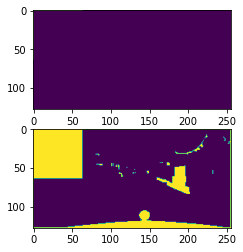

In [ ]:
fig=plt.figure()
plt.subplot(2,1,1)
interseciton_graph=plt.imshow(intersection_map)
plt.subplot(2,1,2)
union_graph=plt.imshow(union_map)

In [ ]:
def drawAnimation(pred_map,truth_map,filename="test.gif"):
    def update(num):
        intersection_map,union_map,value=IoU(pred_map,truth_map,num)
        interseciton_graph.set_data(intersection_map)
        union_graph.set_data(union_map)
        return (interseciton_graph,union_graph)
    ani=animation.FuncAnimation(fig=fig,func=update,frames=np.arange(30),interval=500)
    ani.save(filename)

# Codes to draw dynamic graphs of the intersection and union map

In [ ]:
##########################################
#  uncomment following codes to save gif #
##########################################

# drawAnimation(output_map[0],trainSet[0][1],"test1.gif")
# drawAnimation(output_map[1],trainSet[0][1],"test2.gif")

In [ ]:
truth_batch=torch.stack([trainSet[0][1],trainSet[1][1]])

C:\Users\phyll\AppData\Local\Temp\ipykernel_18256\528393666.py:44: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)
C:\Users\phyll\AppData\Local\Temp\ipykernel_18256\528393666.py:48: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)


# Two alpha Versions for IoU

In [ ]:
def IoU_v_1(pred: torch.tensor,truth:torch.tensor,class_label:int) -> float:
      """
      pred:  [batch, height, width]
      truth: [batch, height, width]
      """
      inter_map=torch.logical_and(pred==class_label,truth==class_label)
      union_map=torch.logical_or(pred==class_label,truth==class_label)
      return inter_map,union_map,inter_map.flatten(1).sum(-1)/union_map.flatten(1).sum(-1)

In [2]:
def IoU(pred: torch.tensor,truth:torch.tensor,class_label:int) -> float:
      """
      pred:  [batch, height, width]
      truth: [batch, height, width]
      """
      inter_map=torch.logical_and(pred==class_label,truth==class_label)
      union_map=torch.logical_or(pred==class_label,truth==class_label)
      result=torch.ones(pred.shape[0])
      non_zero_idx=torch.where(union_map.flatten(1).sum(-1)!=0)
      result[non_zero_idx]=inter_map.flatten(1).sum(-1)[non_zero_idx]/union_map.flatten(1).sum(-1)[non_zero_idx]
      return inter_map,union_map,result

NameError: name 'torch' is not defined

In [ ]:
_,_,value=IoU_v_1(output_map,truth_batch,9)
print(f"nan will occur for non-exists class:{value}")

_,_,value=IoU(output_map,truth_batch,9)
print(f"1 for non-exists class{value}") # IoU for classes not in both ground truth and predition is 1 here

NameError: name 'output_map' is not defined

In [ ]:
results=torch.zeros(output_map.shape[0])
for class_label in range(30):
    _,_,value=IoU(output_map,truth_batch,class_label)
    results+=value
results/=30
print(results.mean().item()) 

0.45414385199546814


# Test for implemented `compute_iou`

In [ ]:
from scripts.metrics import compute_iou
compute_iou(output_batch,truth_batch)

0.45414385199546814

# Show all intersection map and union map

In [1]:
os.chdir("../")
import torch
import os

In [2]:
os.getcwd()

'e:\\Tue_Study\\Q3\\5LSM0_CNN\\5LSM0_Cityscapes_challenge'

In [34]:
def IoU(pred: torch.tensor,truth:torch.tensor,class_label:int) -> float:
      """
      pred:  [batch, height, width]
      truth: [batch, height, width]
      """
      inter_map=torch.logical_and(pred==class_label,truth==class_label)
      union_map=torch.logical_or(pred==class_label,truth==class_label)
      # result=torch.ones(pred.shape[0])
      # non_zero_idx=torch.where(union_map.flatten(1).sum(-1)!=0)
      # result[non_zero_idx]=inter_map.flatten(1).sum(-1)[non_zero_idx]/union_map.flatten(1).sum(-1)[non_zero_idx]
      return inter_map,union_map,inter_map.sum()/union_map.sum()

In [57]:
MODEL_DIR = os.path.abspath("saves")
model = torch.load(os.path.join(MODEL_DIR, "EXP3_r2unet","models", "r2unet_epoch_15.pt")).cpu()

In [58]:
BASELINE_DIR = os.path.abspath("models_trained")
baseline = torch.load(os.path.join(BASELINE_DIR, "U-Net_e1_b10_False.pt"))

In [50]:
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF

In [51]:
from scripts.dataset.dataset import CityscapesDataset,classes

dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val", "test")
}

In [52]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode
import numpy as np
import random

In [68]:
def model_testing(model,ds,num):
    image,truth=ds[num]
    output=model(image.unsqueeze(0)).detach().cpu()
    output_index_map=output.argmax(dim=1).type(torch.uint8).squeeze()
    rows = [] 
    template_table = '<table><thead><tr><th>name</th><th>output</th><th>truth</th><th>inter</th><th>union</th><th>origin</th></tr></thead><tbody>{0}</tbody></table>'

    # HTML templates for displaying random samples in a table
    template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td><td>{5}</td></tr>'
    template_img = '<img src="data:image/png;base64,{0}"/>'

    # for i in [1,3,4,7,19,20,]: # only show first 8 images here
    value_map=[]
    for i in range(30):
        intersection_map,union_map,value=IoU(output_index_map,truth,i)
        output=TF.to_pil_image((output_index_map==i).float())
        inter=TF.to_pil_image(intersection_map.float())
        union=TF.to_pil_image(union_map.float())
        truth_fmap=TF.to_pil_image((truth==i).float())
        # plt.imshow(intersection_map.int()*255)

        # Display a random sample of each split of the dataset
        input = TF.to_pil_image(image)
        # truth_img = ds_split["train"].to_image(truth)
            
        # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
        with BytesIO() as buffer_output, BytesIO() as buffer_inter, BytesIO() as buffer_union, BytesIO() as buffer_truth, BytesIO() as buffer_input: 
            output.save(buffer_output, format='png')
            truth_fmap.save(buffer_truth, format='png')
            inter.save(buffer_inter, format='png')
            union.save(buffer_union, format='png')
            input.save(buffer_input, format='png')

            # Store one row of the dataset
            images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_output,buffer_truth,buffer_inter,buffer_union,buffer_input)]
        if str(value.item()) == "nan": continue
        value_map.append(value)
        rows.append(template_row.format(classes[i].name+" "+str(value.item()),*images))

        # Render HTML table

        # display(output)
        # display(inter)
        # display(union)
    value_map=torch.tensor(value_map)
    value_map_sort_idx=torch.argsort(value_map,descending=True).numpy()
    table = template_table.format(''.join(np.array(rows)[value_map_sort_idx]))
    display(HTML(table))

        # plt.figure()
        # plt.subplot(2,1,1)
        # plt.imshow(intersection_map[0])
        # plt.subplot(2,1,2)
        # plt.imshow(union_map[0])`

1197


name,output,truth,inter,union,origin
vegetation 0.8172252774238586,,,,,
void 0.6673095226287842,,,,,
road 0.666309118270874,,,,,
building 0.6592980623245239,,,,,
sidewalk 0.4324401021003723,,,,,
sky 0.40458014607429504,,,,,
car 0.1879194676876068,,,,,
dynamic 0.0,,,,,
wall 0.0,,,,,
traffic light 0.0,,,,,

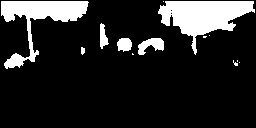
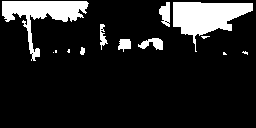
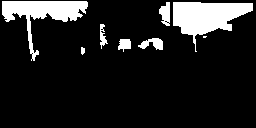
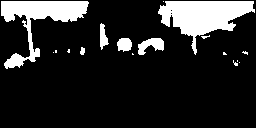
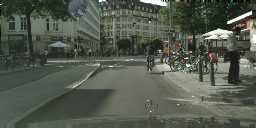
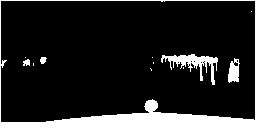
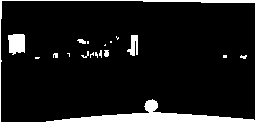
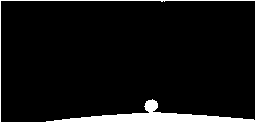
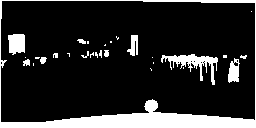
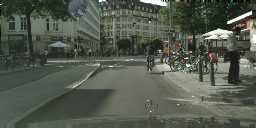
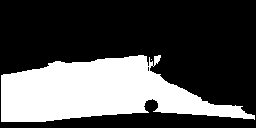
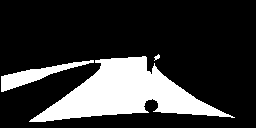
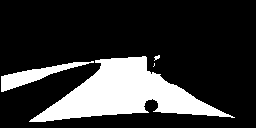
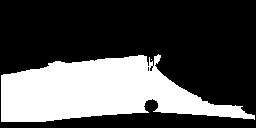
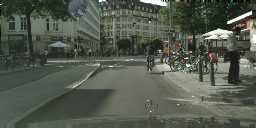
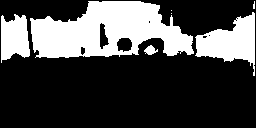
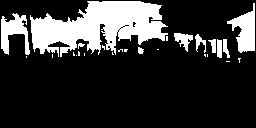
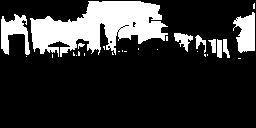
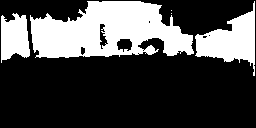
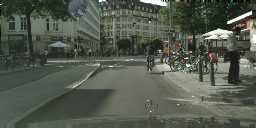
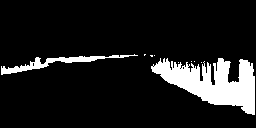
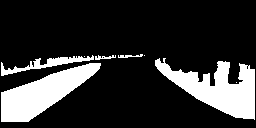
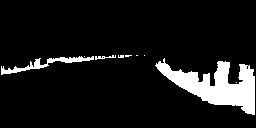
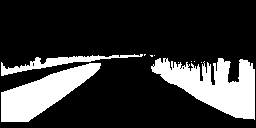
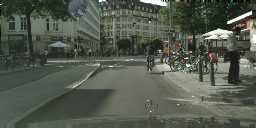
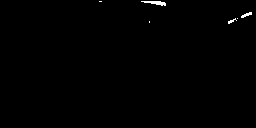
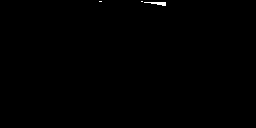
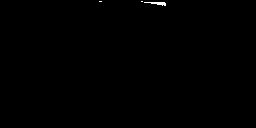
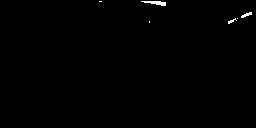
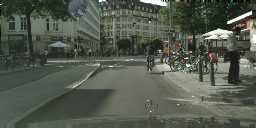
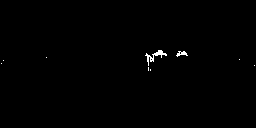
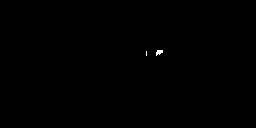
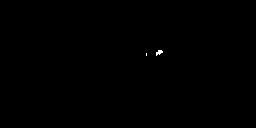
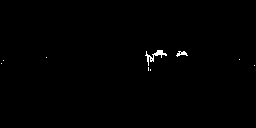
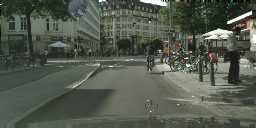
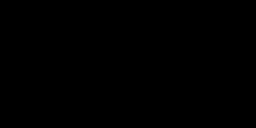
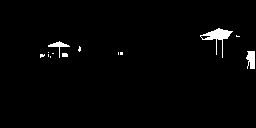
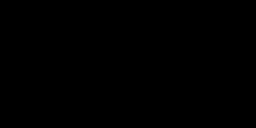
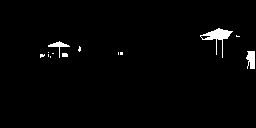
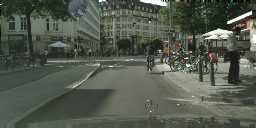
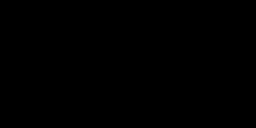
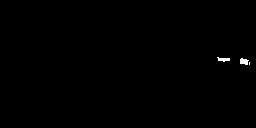
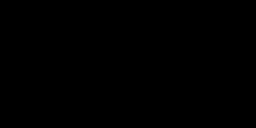
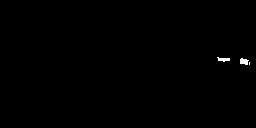
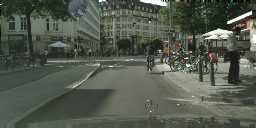
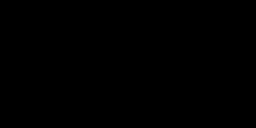
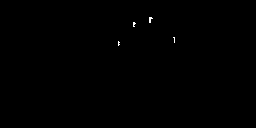
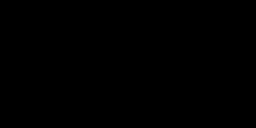
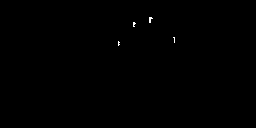
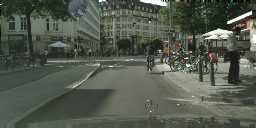
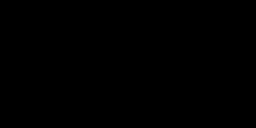
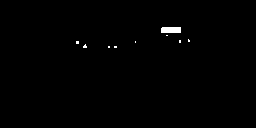
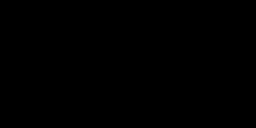
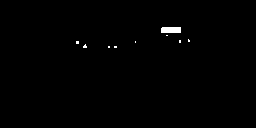
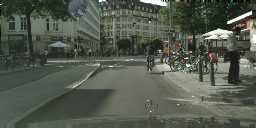
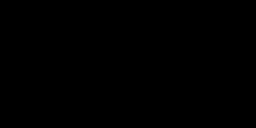
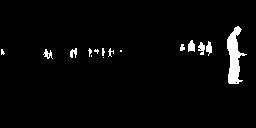
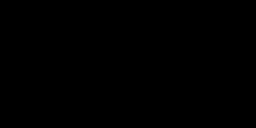
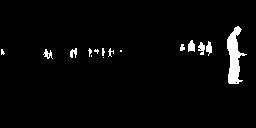
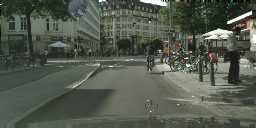
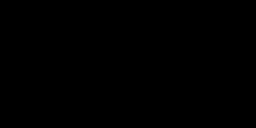
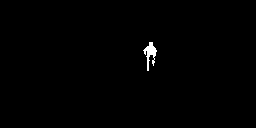
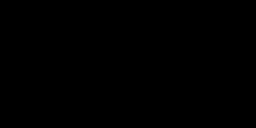
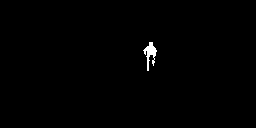
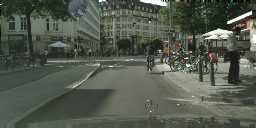
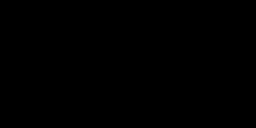
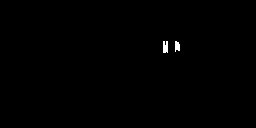
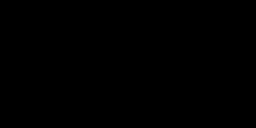
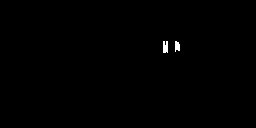
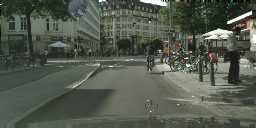
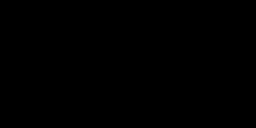
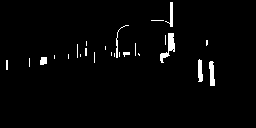
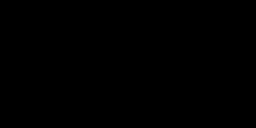
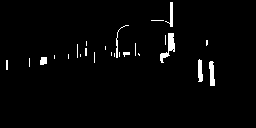
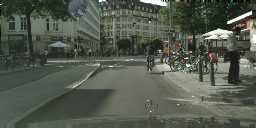
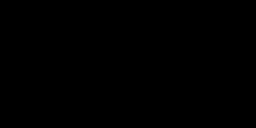
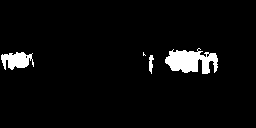
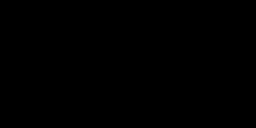
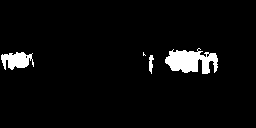
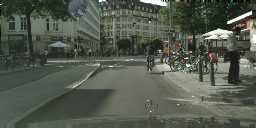

In [69]:
ds=ds_split["train"]
# num = random.randint(0,len(ds))
num = 1197
print(num)
model_testing(model, ds, num)

1197


name,output,truth,inter,union,origin
vegetation 0.7235280871391296,,,,,
building 0.6609355211257935,,,,,
void 0.4029577076435089,,,,,
road 0.32245180010795593,,,,,
sky 0.2531645596027374,,,,,
person 0.15845824778079987,,,,,
sidewalk 0.08457943797111511,,,,,
car 0.01361122913658619,,,,,
dynamic 0.0,,,,,
wall 0.0,,,,,

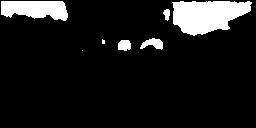
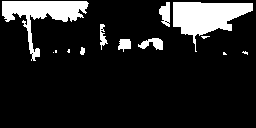
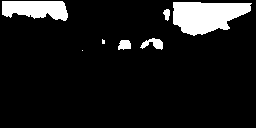
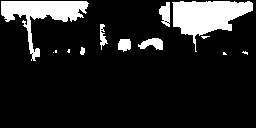
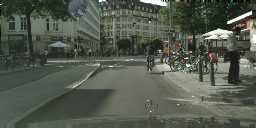
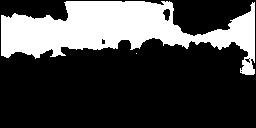
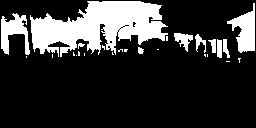
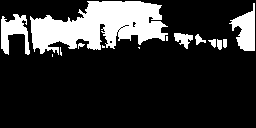
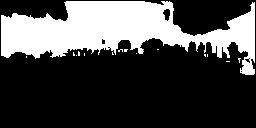
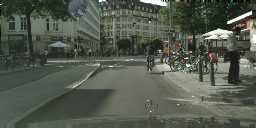
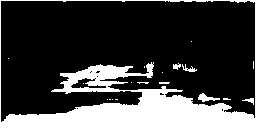
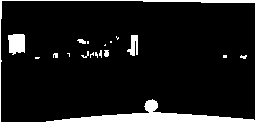
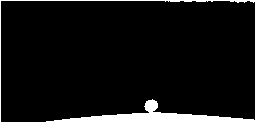
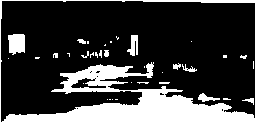
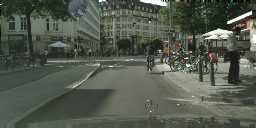
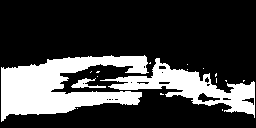
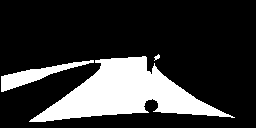
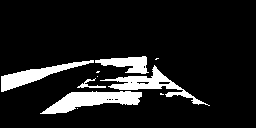
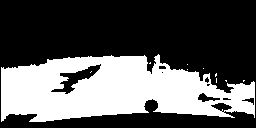
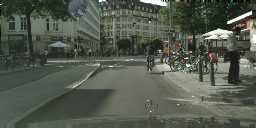
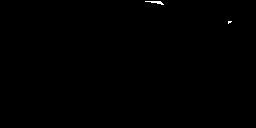
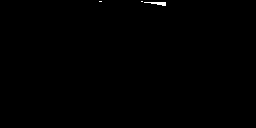
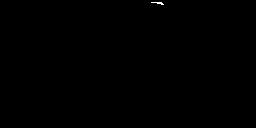
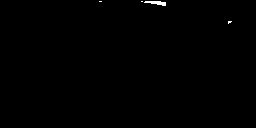
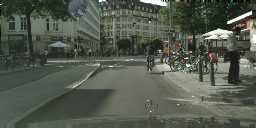
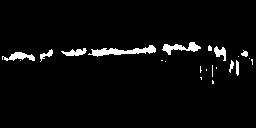
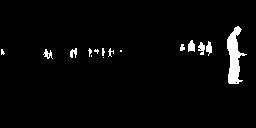
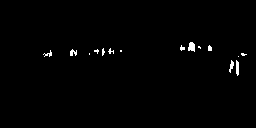
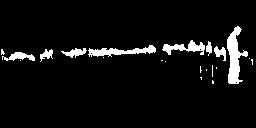
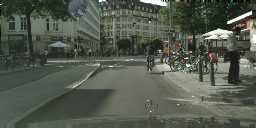
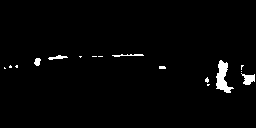
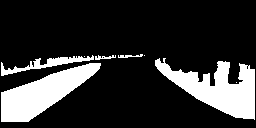
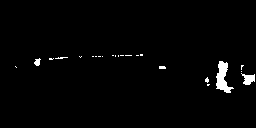
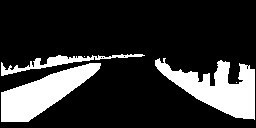
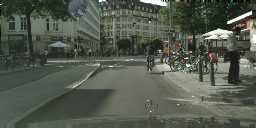
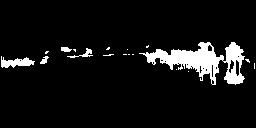
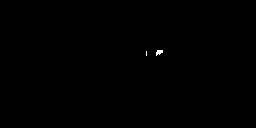
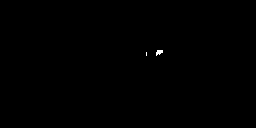
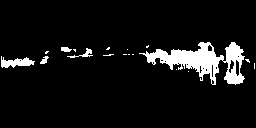
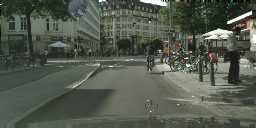
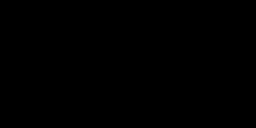
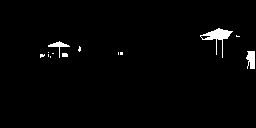
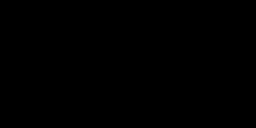
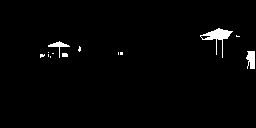
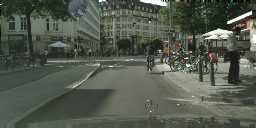
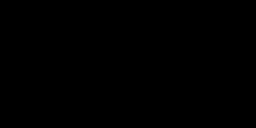
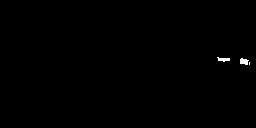
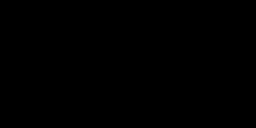
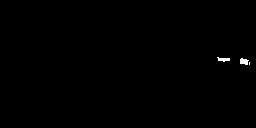
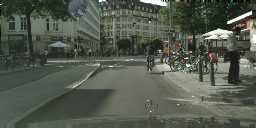
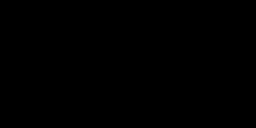
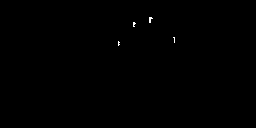
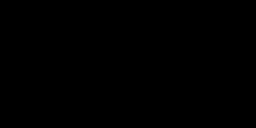
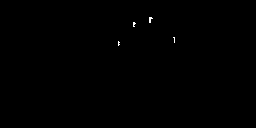
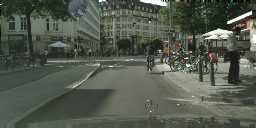
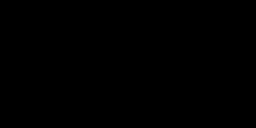
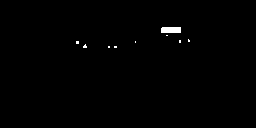
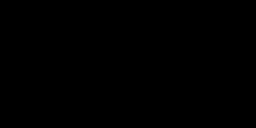
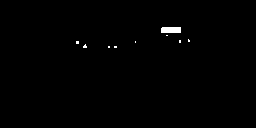
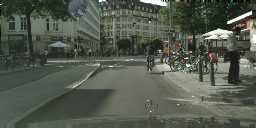
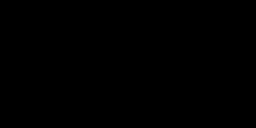
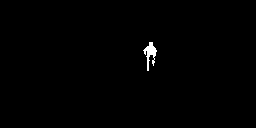
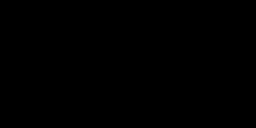
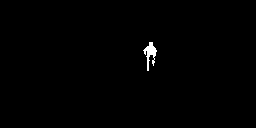
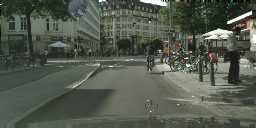
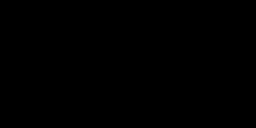
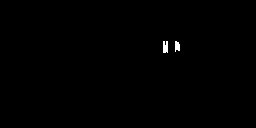
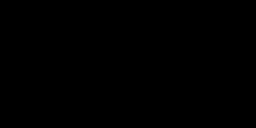
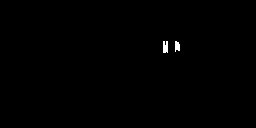
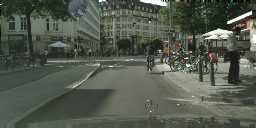
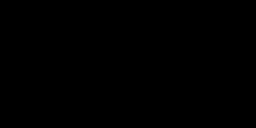
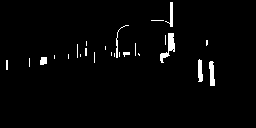
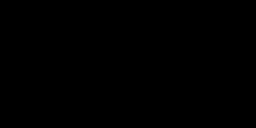
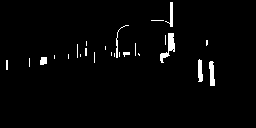
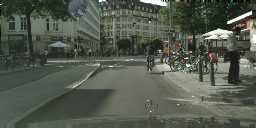
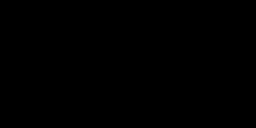
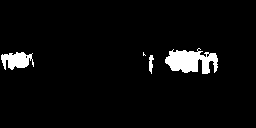
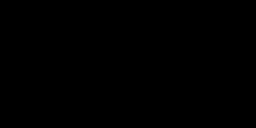
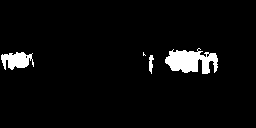
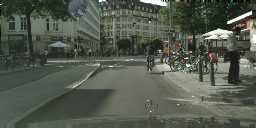

In [70]:
ds=ds_split["train"]
# num = random.randint(0,len(ds))
num = 1197
print(num)
model_testing(baseline, ds, num)

In [54]:
img=TF.to_pil_image(image)
img.show()